# [NTDS'17] assignment 1: Student Solution
[ntds'17]: https://github.com/mdeff/ntds_2017

Florian Benedikt Roth

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [1]:
%matplotlib inline

import os
import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle 
from datetime import datetime
from pprint import pprint
import tweepy 

In [5]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read(os.path.join('..','Data', 'credentials.ini'))

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [6]:
user = 'RohdeSchwarz'                       #'appliedmldays' #'tudresden_de' #'barkhausensarmy' 
user_obj = api.get_user(user)               #'RohdeSchwarz'  #'dl_weekly'
user_id =  user_obj.id

print('The chosen user {} has {} followers and {} friends'.format(user_obj.screen_name, user_obj.followers_count, user_obj.friends_count))

The chosen user RohdeSchwarz has 6339 followers and 455 friends


In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user. Friend means, that the user is a follower of the given account.

In [7]:
def find_connections(user_id, limit_min=5):
    followers = []
    friends=[]
    connections = []
    #limit_min = 5   # limit in minutes per node that the programm will wait additionally to get all friends and followers
                     # if limit would be reached, the user will be replaced
                     # take into account that this will decrease the probability of users with many connections
                     # set to -1 to wait as long as it takes
                     # 5000 follower/friends ~ 1 minute
    
    user_obj = api.get_user(user_id)
    name ,fol_cnt, fri_cnt = user_obj.screen_name, user_obj.followers_count, user_obj.friends_count
    
    # ask for number of followers & friends so that requests, that would take too long are filtered
    if max(fol_cnt, fri_cnt) > 5000:
        minutes = np.ceil(max(fol_cnt,fri_cnt)/5000-1)
        if limit_min < 0:
            print('# Because {}/{} has {} followers and {} friends the time waiting for \n  the rate limit to reset will increase by ~ {} minutes.'.format(name,user_id,fol_cnt,fri_cnt,minutes))
        elif minutes > limit_min:
            print('# Because {}/{} has {} followers and {} friends the time waiting for \n  the rate limit to reset would increase by ~ {} minutes.'.format(name,user_id,fol_cnt,fri_cnt,minutes))
            print('  Due to the chosen limit of {} minutes per node this user will be replaced'.format(limit_min))
            connections = [float('Nan')]
            return connections
        
    # get followers_ids & friends_ids
    try:
        for fol in tweepy.Cursor(api.followers_ids, user_id).pages():
            followers.extend(fol)
        for fr in tweepy.Cursor(api.friends_ids, user_id).pages():
            friends.extend(fr)
            
    # if user does not allow accessing its friends & followers -> return Nan
    except tweepy.TweepError:
        print('# Could not access the followers/friends of the user {}/{}'.format(name,user_id))
        connections = [float('Nan')]
        return connections
    
    # find connections as intersections between friends & followers
    connections = list(np.intersect1d(followers,friends))
    return connections

In [8]:
first_connections = find_connections(user_id,-1)
if np.isnan(first_connections[0]):
    print('Choose a new starting nod.')
else:
    print('{} has {} connections'.format(user, len(first_connections)))

# Because RohdeSchwarz/53101979 has 6339 followers and 455 friends the time waiting for 
  the rate limit to reset will increase by ~ 1.0 minutes.
RohdeSchwarz has 209 connections


Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [308]:
def calc_time(level, how_many):
    # This function calculates how long the collecting data part will last under the following assumptions:
    # 1) all the users share their followers & friends
    # 2) no one has more than 5000 followers or friends OR limit_min = 0 
    #     -> would lead to multiple requests per node otherwise
    # 3) all nodes have at least 'how_many' connections
    # 
    # real network neglecting A1 & A2 -> takes more time
    # real network neglecting A3      -> takes less time
    
    n_max = 0
    for i in range(0,level+1):       # calculating N_max
        n_max += how_many**(i)
    
    # get remaining api requests in rate limit slot and and time of reset
    remaining = api.rate_limit_status()['resources']['friends']['/friends/ids']['remaining']
    reset = api.rate_limit_status()['resources']['friends']['/friends/ids']['reset']
    
    # add the amount of needed time_slots * seconds/time_slot to time of reset
    reset += np.floor((n_max-remaining)/15)*15*60
    print('The network you create will have up to {} nodes.'.format(n_max)) 
    print(datetime.fromtimestamp(reset).strftime('Due to restrictions of the twitter API this takes about until %H:%M o\'clock'))
    return

In [309]:
def get_nodes(n, collection, but=[]):
    # This function provides n random nodes from the given collection
    # excluding the entries in 'but'
    nodes = []
    i = 0
    
    flat = [x for sublist in but for x in sublist]          # list of lists -> list containing all elements
    
    if not set(collection) <= set(flat):                    # dont start if entire collection is excluded
        pool = list(set(collection)-set(flat))              # pool to choose from
        
        # stop when: 1) n nodes are found, or 2) no free nodes are left
        for i in range(0,min(n, len(pool))):
            k = random.randint(0,len(pool)-1)       # choose a random element out of the pool
            nodes.append(pool[k])                   # add it to the chosen nodes
            pool.remove(pool[k])                    # and delete it from the pool
    return nodes

In [310]:
from IPython.core.debugger import Tracer   # for debugging insert Tracer()()  

# This functions collects 'cpn' (connections/node) connections for every node in 'nodes',
# saves them in 'nodes_on_lvl', saves nodes with all corresponding connections in all_con,
# and calls itself until the lowest level (0) is reached.
def build_network(nodes, all_con, cpn, level, nodes_on_lvl = [], calling_nod = -1):
    
    # only called the first time in the highest level to add nodes to nodes_on_lvl 
    if len(nodes_on_lvl) < (level+1):
        nodes_on_lvl.extend([[]]*(level+1))
        nodes_on_lvl[level] = nodes
    trash = []                      # collect nodes that dont allow to access their friends&followers in here
    
    # iteration, get connections for every node
    for nod in nodes:
        # get connections from the twitter api
        connections = find_connections(nod)

        # user doesnt share connections
        if np.isnan(connections[0]):
            if calling_nod is -1:       # 'nodes' is starting nod (user_id)
                print('  -> Choose another starting nod!')
            else:                       # replace the node
                nodes_on_lvl[level].remove(nod)  # delete invalid node from structure
                trash.append(nod)                # dont remove invalid node from 'nodes', otherwise next node will be skipped
                
                # get one random node, that is connected to the calling node in the level above 
                # but not already in the network
                new_nod = get_nodes(1,all_con[calling_nod],nodes_on_lvl)                
                
                if len(new_nod) > 0:             # get_nodes found a new node
                    nodes.extend(new_nod)        # adding is allowed and for loop will iterate over new_nod as well
                    nodes_on_lvl[level].extend(new_nod)
                    name = api.get_user(new_nod[0]).screen_name
                    print('  level {}: user was was replaced by {}/{}'.format(level,name,new_nod[0]))
                else:
                    print('  level {}: user was deleted'.format(level))
                
        # user shares connections
        else:
            all_con[nod] = connections                 # node with all corresponding connections is saved in dictionary
            if level > 0:                                              ## in every level except for the lowest:
                nxt_nodes = get_nodes(cpn, connections, nodes_on_lvl)   # choose cpn connections as next nodes
                sublist = copy.deepcopy(nodes_on_lvl[level-1])          # add chosen nodes to structure
                sublist.extend(nxt_nodes)
                nodes_on_lvl[level-1] = sublist
                
                # call function on the next lower level
                build_network(nxt_nodes,all_con,cpn,level-1,nodes_on_lvl,nod)
                
    for element in trash:
        nodes.remove(element)                          # remove invalid nodes AFTER iterating over all nodes
    return

In [311]:
all_connections = {} # dictionary for all connections => saves api requests
nodes_on_lvl=[]      # list of sublists containing nodes of a certain level in the network

level = 2            # depth of network; in this task: level = 2
how_many = 10        # This is the number of connections you are sampling. 
                     # Keep small (e.g.3) for development, larger later (e.g. 10)

    
# make a guess how long the collection of data will take
calc_time(level, how_many)

# this function collects and assembles the data. 
build_network([user_id], all_connections, how_many, level, nodes_on_lvl)

# assign the collected data from nodes_on_lvl to the different lists of nodes
first_nodes = nodes_on_lvl[level-1]
second_nodes = nodes_on_lvl[level-2]
all_nodes = [x for sublist in nodes_on_lvl for x in sublist]


print(datetime.now().time().strftime('*** Collected all data from twitter at %H:%M o\'clock ***'))

The network you create will have up to 111 nodes.
Due to restrictions of the twitter API this takes about until 00:13 o'clock
# Could not access the followers/friends of the user nomadtechnical/111391043
  level 0: user was was replaced by ITCTestWeek/174143998
Rate limit reached. Sleeping for: 889
Rate limit reached. Sleeping for: 890
# Because BluprintAcademy/19837231 has 65908 followers and 70954 friends the time waiting for 
### the rate limit to reset would increase by ~ 14.0 minutes.
  Due to the chosen limit of 5 minutes per node this user will be replaced
  level 0: user was was replaced by gsohn/16905041
Rate limit reached. Sleeping for: 889
Rate limit reached. Sleeping for: 890
Rate limit reached. Sleeping for: 889
# Because GreatnessHQ/786223237 has 33874 followers and 27623 friends the time waiting for 
### the rate limit to reset would increase by ~ 6.0 minutes.
  Due to the chosen limit of 5 minutes per node this user will be replaced
  level 0: user was was replaced by a

**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [312]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 10 first hop nodes
There are 91 second hop nodes
There are overall 102 nodes in the collected network


Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [313]:
# now all connections and not only the inner connections are found here
# possible connections that would miss anyways: 
# first-first, first-second, second-second, start-second
network = {}
for a in all_nodes:
    # using intersection between all nodes and all connections of one node
    network[a] = list(np.intersect1d(all_connections[a], all_nodes))

In [314]:
pprint(network)

{14447771: [17781604,
            30056032,
            59083754,
            87246782,
            214976509,
            415627631,
            953457997],
 14487859: [35863756],
 15343458: [2765811500],
 15756829: [17781604,
            25315996,
            25355790,
            26590759,
            30056032,
            35863756,
            43334583,
            44682474,
            53101979,
            80735533,
            84079827,
            174143998,
            214976509],
 15833882: [57697965],
 16544249: [35863756, 921680064],
 16905041: [36327152, 57697965, 135984800, 205181291, 337727729],
 16998179: [35863756],
 17781604: [14447771,
            15756829,
            25315996,
            26590759,
            30056032,
            34478091,
            43334583,
            44682474,
            80735533,
            84079827,
            97561729,
            214976509,
            415627631,
            953457997],
 19013088: [28180307, 768731503],
 19080487: [5

In [315]:
# to avoid doing the time consuming collection of data multiple times for 
# the same network here is the possibility to save it in a pickle file
save = True
if save:
    f = open('{}_{}_{}.p'.format(user,level,how_many),'wb')
    pickle.dump(network,f)
    f.close()
    print('The created network was saved in {}_{}_{}.p'.format(user,level,how_many))

The created network was saved in RohdeSchwarz_2_10.p


# 2. Discover some of the properties of the collected network

In [2]:
# to save time it is possible to load some collected network data from a pickle file
load = True
filename = 'RohdeSchwarz_2_10.p'           # startinguser_level_howmany.p

# avaliable networks:        'dl_weekly_2_3.p'       'dl_weekly_2_4.p'      'dl_weekly_2_5.p'
#                            'appliedmldays_2_2.p'   'tudresden_de_2_8.p'   'RohdeSchwarz_2_10.p'

if load:
    network = {}
    f = open(filename,'rb')
    network = pickle.load(f)
    f.close()
    all_nodes = []
    for key in network:
        all_nodes.append(key)         # create all_nodes with the loaded network data
    print('The network from {} was loaded'.format(filename))

The network from RohdeSchwarz_2_10.p was loaded


## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [3]:
# preparation for creatign the matrix: 
# 1) empty quadratic matrix of correct size 
W = np.zeros([len(all_nodes),len(all_nodes)], dtype=int)
# 2) dictionary with nod -> index, that will be position in matrix
code = {}   
for ind,k in enumerate(network):         
    code[k] = ind
    
# create matrix applying the node-index transform
for nod in network:
    for connection in network[nod]:
        W[code[nod]][code[connection]] = 1

Remember that a weight matrix should be symmetric. Check if it is:  
This code was combined with the next part, so that checking and fixing if needed are combined.

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:** Depending on the implementation one can get a non-symmetric weight matrix W, if one does not assign the connection from a to b automatically to b to a. If one does that but checks before the friends and followers of twitter user b, one can run into a problem in the case that the twitter user does not allow to enter its connections followers and friends. Another problem would occur if one finds not all connections of a user. This can happen if the function find_connections does not use the Cursor object and the amount of found friends and followers is 5000 as maximum.  
In this implementation though:
* twitter users, that dont allow to access their connections are replaced if possible, otherwise deleted
* the cursor object is used

Impose your weight matrix to be symmetric.

In [4]:
# check if matrix is symmetric
if len(W[np.nonzero(W-W.transpose())]) is not 0:
    # Make W symmetric
    bigger = W.transpose() > W       # bigger is True, where a connection in W is missing
    W = W - W*bigger + W.transpose()*bigger   # The term 'W*bigger' is only for security, W should be zero at these points
    print('W was not symmetric but it is now')
else:
    print('W is symmetric')

W is symmetric


Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

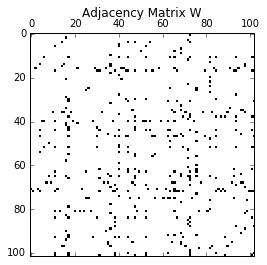

In [5]:
# visualize matrix
plt.spy(W)
plt.title('Adjacency Matrix W')
plt.show()

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**
* Complete network: In a complete network, every nod has a link to every other node. Therefore  
$L_{max} = \frac{N\dot(N-1)}{2}$
* For this created network we neglect the amount of connections, that were missed because of the sampling and we assume, that every node has at least how_many (in the formula $n$) nodes. Taking into account the depth or level of the network $l$, that was for this assignment $l=2$, the amount of nodes is  
$N = 1+n+n^{2}+...+n^{l} = \sum_{i=0}\limits^{l}n^{i}$  
The amount of links is  
$L = n+n^{2}+...+n^{l} = \sum\limits_{i=1}^{l}n^{i}$  
Therefore the amount of links can be expressed as $L = N-1$  
* For $N >> 1$ the amount of links grows for a complete net work with $L_{max} \sim N^{2}$  
and for our specific network with $L \approx N$ 


## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [6]:
# sum of row/column equals connections of specific user
p = W.sum(1)

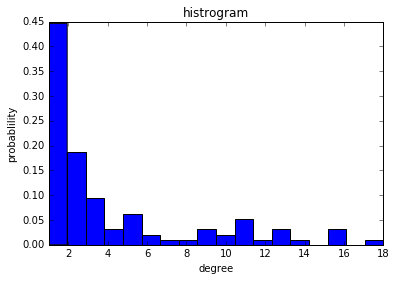

In [7]:
plt.hist(p,max(p),normed=1);     # hist does the rest of the work, normed returns probablilities
plt.xlabel('degree')
plt.ylabel('probablility')
plt.title('histrogram')
plt.xlim([1,max(p)])
if max(p) < 10:
    plt.xticks(np.arange(1,max(p)+1,1))               # avoid decimal values as ticks which dont make sense at a histogram

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

**Your answer here:**  
In this collected dataset there are a lot of nods having only one connection. Then the amount decreases very fast, roughly with $\frac{1}{k}$ keeping it at a low but quite constant level for higher values of $k$. The maximum degree in this network is 18.  
I think, that the histogram of the complete Twitter network would look similar with a minor difference.  Probably the degree with the highest probability is not 1 but slightly higher. Almost every user shares a couple connections and the reason we found that many in our data set with only one connection is, that we stopped after the second_nodes and did not continue going on. Apart from that I think it looks similar with only a few users having a very big amount of connections. 

## 2.3 Average degree

Calculate the average degree of your collected network.

In [8]:
# p: degree per nod -> mean(p): average degree
d_avg = np.mean(p)

## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

**Your answer here:** 
The maximum distance between two nodes of the network is 4, because we went only 2 layers down from the starting user_id. This makes a maximum distance of 2 hops up from the bottom layer to user_id and from there 2 hops down to another node in the base layer. 

## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [9]:
# collect the indices of nodes that have a lower degree than average
indices = []
for ind,nods in enumerate(p):
    if nods < d_avg:
        indices.append(ind)

In [10]:
# create the pruned matrix by deleting the rows and columns to the belonging indices
Wpruned = np.delete(copy.copy(W),indices,0)
Wpruned = np.delete(Wpruned,indices,1)

# compare d_avg to before
d_avg_p = np.mean(Wpruned.sum(1))
print('By pruning the average degree of the network changed form {0:.3f} to {1:.3f}'.format(d_avg,d_avg_p))

By pruning the average degree of the network changed form 4.000 to 6.500


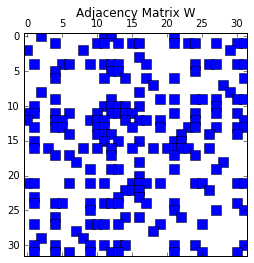

In [11]:
plt.spy(Wpruned, markersize=10)
plt.title('Adjacency Matrix W');